In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from deepmotion import registration
from deepmotion.simulations import simu3d
from deepmotion.utils import montage

[64, 64, 33] [31 31 15]
[16 16  0]


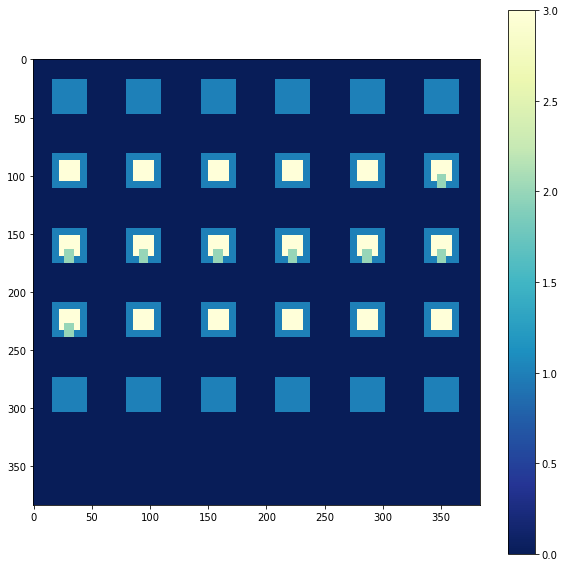

In [16]:
ref_vol,v2w = simu3d.object_generator([64,64,33], [30, 30, 30])

plt.figure(figsize=(10,10))
plt.imshow(montage.transform(ref_vol),cmap=plt.get_cmap('YlGnBu_r'))
plt.colorbar()

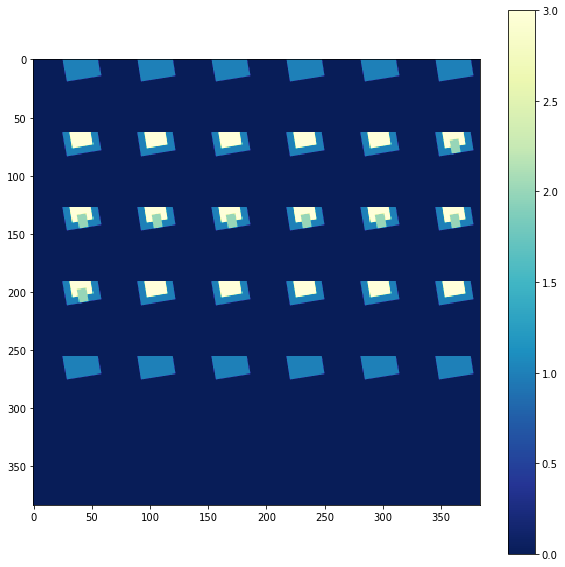

In [4]:
reload(registration)
coreg_vol, transf = registration.transform(ref_vol,[10.,30.,0,0,0,10],v2w)

plt.figure(figsize=(10,10))
plt.imshow(montage.transform(coreg_vol),cmap=plt.get_cmap('YlGnBu_r'))
plt.colorbar()

# Apply signal


In [5]:
hr_vols = simu3d.apply_signal(ref_vol,1000,binary_threshold=0.2)

(768, 1000)


# Avg Pooling reference


In [6]:
lr_vols = simu3d.avgpool3d(hr_vols, k=3)

# Apply motion


In [7]:
motion_params= np.zeros((1000, 6))
motion_params[:,[0,1,2]] = np.random.randn(1000,3)*0.5+2.
motion_params[:,[3,4,5]] = np.random.randn(1000,3)*2.+1.

hr_vols_motion = simu3d.apply_motion(hr_vols, v2w, motion_params)

In [8]:
motion_params[:,[5]]

array([[ -1.11334962e+00],
       [ -1.37241669e+00],
       [  4.69427383e+00],
       [  1.33854925e+00],
       [  1.34459166e+00],
       [ -1.28384491e+00],
       [  1.89473491e+00],
       [  1.14253474e+00],
       [  2.25031214e+00],
       [  1.44622253e+00],
       [  2.15325097e+00],
       [  3.55525273e+00],
       [  2.24641819e+00],
       [  5.49006273e+00],
       [ -8.37266174e-01],
       [ -1.00665098e+00],
       [  1.50120561e+00],
       [  1.29265965e+00],
       [  6.13448241e+00],
       [  2.38373074e+00],
       [  1.15234189e+00],
       [  1.73036062e+00],
       [  2.68987045e+00],
       [  5.20936597e-01],
       [  7.09220788e-01],
       [  3.34581423e+00],
       [ -9.69324320e-01],
       [ -5.44835668e-01],
       [  1.62561816e+00],
       [ -3.31886495e-01],
       [ -3.59396770e-01],
       [ -5.51792143e-01],
       [  3.20919440e-01],
       [ -3.94869575e-01],
       [  2.71051840e+00],
       [  5.44374590e-01],
       [  1.09136370e+00],
 

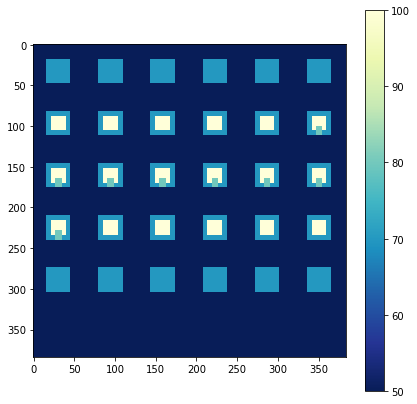

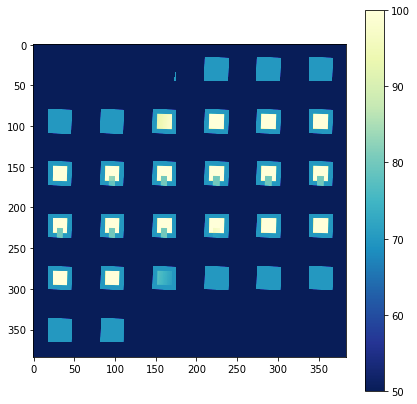

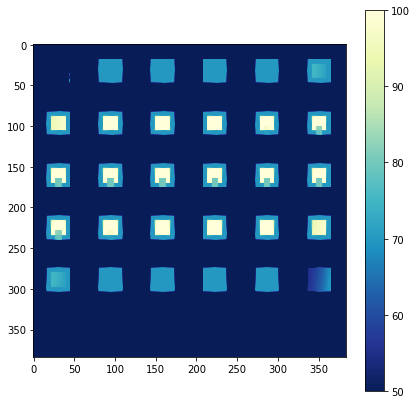

In [9]:
reload(registration)
plt.figure(figsize=(7,7))
plt.imshow(montage.transform(hr_vols[5,:,:,:]),cmap=plt.get_cmap('YlGnBu_r'),vmin=50,vmax=100)
plt.colorbar()


plt.figure(figsize=(7,7))
plt.imshow(montage.transform(hr_vols_motion[5,:,:,:]),cmap=plt.get_cmap('YlGnBu_r'),vmin=50,vmax=100)
plt.colorbar()

coreg_vol, transf = registration.transform(hr_vols_motion[5,:,:,:],motion_params[5],v2w,inv_affine=True)
plt.figure(figsize=(7,7))
plt.imshow(montage.transform(coreg_vol),cmap=plt.get_cmap('YlGnBu_r'),vmin=50,vmax=100)
plt.colorbar()

# Avg Pooling with noise


In [10]:
lr_vols_motion = simu3d.avgpool3d(hr_vols_motion, k=3)
lr_vols_motion = lr_vols_motion + np.random.randn(*lr_vols_motion.shape)  

# Linear correction inv transf


In [11]:
v2w_lr = v2w.copy()
v2w_lr[:3,:3] = v2w[:3,:3]*3.
v2w_lr[:-1,3] = v2w[:-1,3]
reload(registration)
reload(simu3d)

lr_vols_motion_cor = simu3d.apply_motion(lr_vols_motion, v2w_lr, motion_params, inv_affine=True)

In [12]:
lr_vols_motion_cor.shape

(1000, 22, 22, 11)

# Motion field

In [13]:
# create displacement field
motion_field = registration.displacement_field(np.eye(4),motion_params, lr_vols.shape[1:])%3.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(0, 2026.7051)
(1, 2447.656)
(2, 155.46965)
(3, 127.01621)
(4, 138.78008)
(5, 128.08875)
(6, 117.27971)
(7, 114.32666)
(8, 118.4258)
(9, 113.70964)
(10, 28, 28, 1)


/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


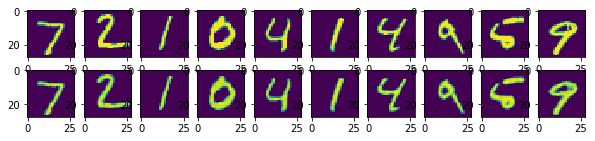

In [14]:
"""Tutorial on how to create a convolutional autoencoder w/ Tensorflow.

Parag K. Mital, Jan 2016
"""
import tensorflow as tf
import numpy as np
import math


# %%
def autoencoder(input_shape=[None, 28,28,1],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build a deep denoising autoencoder w/ tied weights.

    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description

    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training

    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')


    # %%
    # ensure 2-d is converted to square tensor.
    
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x.get_shape()) == 4:
        x_tensor = x
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Optionally apply denoising autoencoder
    if corruption:
        #current_input = corrupt(current_input)
        print 'co corrupt'

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = tf.nn.relu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = tf.nn.relu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}


# %%
def test_mnist():
    """Test the convolutional autoencder using MNIST."""
    # %%
    import tensorflow as tf
    import tensorflow.examples.tutorials.mnist.input_data as input_data
    import matplotlib.pyplot as plt

    # %%
    # load MNIST as before
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    mean_img = np.mean(mnist.train.images, axis=0)
    ae = autoencoder()

    # %%
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # %%
    # Fit all training data
    batch_size = 100
    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            train = np.array([img - mean_img for img in batch_xs])
            train = np.reshape(batch_xs,(100,28,28,1))
            sess.run(optimizer, feed_dict={ae['x']: train})
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

    # %%
    # Plot example reconstructions
    n_examples = 10
    test_xs, _ = mnist.test.next_batch(n_examples)
    #test_xs_norm = np.array([img - mean_img for img in test_xs])
    test_xs_norm = np.reshape(test_xs,(n_examples,28,28,1))
    recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
    print(recon.shape)
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(test_xs[example_i, :], (28, 28)))
        #axs[1][example_i].imshow(
        #    np.reshape(
        #        np.reshape(recon[example_i, ...], (784,)) + mean_img,
        #        (28, 28)))
        axs[1][example_i].imshow(
            recon[example_i, ...,0])
    fig.show()
    plt.draw()
    #plt.waitforbuttonpress()
    
    return [test_xs, np.reshape(test_xs_norm,(n_examples,28,28,1)),recon]


# %%
#if __name__ == '__main__':
daaaa = test_mnist()

In [46]:
from tensorflow.python.ops import array_ops, sparse_ops
from tensorflow.python.framework import sparse_tensor
# SHAPE OPERATIONS
py_all = all

def is_sparse(tensor):
    """Returns whether a tensor is a sparse tensor.
    Arguments:
      tensor: A tensor instance.
    Returns:
      A boolean.
    Example:
    ```python
      >>> from keras import backend as K
      >>> a = K.placeholder((2, 2), sparse=False)
      >>> print(K.is_sparse(a))
      False
      >>> b = K.placeholder((2, 2), sparse=True)
      >>> print(K.is_sparse(b))
      True
    ```
    """
    return isinstance(tensor, sparse_tensor.SparseTensor)

def to_dense(tensor):
    """Converts a sparse tensor into a dense tensor and returns it.
    Arguments:
      tensor: A tensor instance (potentially sparse).
    Returns:
      A dense tensor.
    Examples:
    ```python
      >>> from keras import backend as K
      >>> b = K.placeholder((2, 2), sparse=True)
      >>> print(K.is_sparse(b))
      True
      >>> c = K.to_dense(b)
      >>> print(K.is_sparse(c))
      False
    ```
    """
    if is_sparse(tensor):
        return sparse_ops.sparse_tensor_to_dense(tensor)
    else:
        return tensor

def concatenate(tensors, axis=-1):
    """Concatenates a list of tensors alongside the specified axis.
    Arguments:
      tensors: list of tensors to concatenate.
      axis: concatenation axis.
    Returns:
      A tensor.
    """
    if axis < 0:
        rank = ndim(tensors[0])
        if rank:
            axis %= rank
        else:
            axis = 0

    if py_all([is_sparse(x) for x in tensors]):
        return sparse_ops.sparse_concat(axis, tensors)
    else:
        return array_ops.concat([to_dense(x) for x in tensors], axis)


def resize_volumes(x, depth_factor, height_factor, width_factor, data_format='channels_last'):
    """Resizes the volume contained in a 5D tensor.
    Arguments:
      x: Tensor or variable to resize.
      depth_factor: Positive integer.
      height_factor: Positive integer.
      width_factor: Positive integer.
      data_format: One of `"channels_first"`, `"channels_last"`.
    Returns:
      A tensor.
    Raises:
      ValueError: if `data_format` is neither
          `channels_last` or `channels_first`.
    """
    if data_format == 'channels_first':
        output = repeat_elements(x, depth_factor, axis=2)
        output = repeat_elements(output, height_factor, axis=3)
        output = repeat_elements(output, width_factor, axis=4)
        return output
    elif data_format == 'channels_last':
        output = repeat_elements(x, depth_factor, axis=1)
        output = repeat_elements(output, height_factor, axis=2)
        output = repeat_elements(output, width_factor, axis=3)
        return output
    else:
        raise ValueError('Invalid data_format:', data_format)


def repeat_elements(x, rep, axis):
    """Repeats the elements of a tensor along an axis, like `np.repeat`.
    If `x` has shape `(s1, s2, s3)` and `axis` is `1`, the output
    will have shape `(s1, s2 * rep, s3)`.
    Arguments:
      x: Tensor or variable.
      rep: Python integer, number of times to repeat.
      axis: Axis along which to repeat.
    Raises:
      ValueError: In case `x.shape[axis]` is undefined.
    Returns:
      A tensor.
    """
    x_shape = x.get_shape().as_list()
    if x_shape[axis] is None:
        raise ValueError('Axis ' + str(axis) + ' of input tensor '
                         'should have a defined dimension, but is None. '
                         'Full tensor shape: ' + str(tuple(x_shape)) + '. '
                         'Typically you need to pass a fully-defined '
                         '`input_shape` argument to your first layer.')
    # slices along the repeat axis
    splits = array_ops.split(value=x, num_or_size_splits=x_shape[axis], axis=axis)
    # repeat each slice the given number of reps
    x_rep = [s for s in splits for _ in range(rep)]
    return concatenate(x_rep, axis)

In [15]:
def glorot_uniform(shape):
    fan_in, fan_out = _compute_fans(shape)
    scale = 1
    scale /= max(1., float(fan_in + fan_out) / 2)
    
    limit = np.sqrt(3. * scale)
    return tf.random_uniform(shape, -limit, limit)
        
def _compute_fans(shape):
    receptive_field_size = np.prod(shape[:2])
    fan_in = shape[-2] * receptive_field_size
    fan_out = shape[-1] * receptive_field_size
    return fan_in, fan_out

def weight_variable(shape):
    #fan_in = shape[-2]
    #fan_out = shape[-1]
    #xavier_stddev = 2. / (fan_in + fan_out)
    #initial = tf.truncated_normal(shape, stddev=xavier_stddev)
                                  
    #tf.truncated_normal(
    return tf.Variable(glorot_uniform(shape))
    #tf.uniform_unit_scaling_initializer()
    #return tf.get_variable('w',shape=shape, initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    #       initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1],
                        strides=[1, 2, 2, 2, 1], padding='SAME')

def inference(input_shape=[None, 22,22,10,1],
         input_shape_m=[None, 22,22,10,3],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build the fMRI model.

    Args:
    images: Images returned from distorted_inputs() or inputs().

    Returns:
    Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # %%
    
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    m = tf.placeholder(
        tf.float32, input_shape_m, name='m')
    t = tf.placeholder(
        tf.float32, input_shape, name='t')
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)
    #keep_prob=1.
    ### BRANCH 3d images
    with tf.variable_scope('img_conv1_1') as scope:
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, 1, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(x, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
       
    
    '''
    with tf.variable_scope('img_conv1_2') as scope:
        nfeaturemap = 32
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    '''
    # Max pooling
    current_input = max_pool_2x2(current_input)


    with tf.variable_scope('img_conv2_1') as scope:
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    #'''    
    with tf.variable_scope('img_conv2_2') as scope:
        nfeaturemap = 512
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    #'''    
    
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv2_3') as scope:
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = resize_volumes(current_input, 2, 2, 2)

    '''
    with tf.variable_scope('img_deconv1') as scope:
        nfeaturemap = 512
        W = weight_variable([3, 3, 3, nfeaturemap, input_nfeaturemap])
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3], nfeaturemap]), 
                                        strides=[1, 2, 2, 2, 1], 
                                        padding='SAME',
                                       name='Deconvolution1')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    '''
    #current_input = tf.contrib.keras.layers.UpSampling3D(current_input, size=2)
    
    #'''
    branch_image = current_input

    ### BRANCH motion parameters
    with tf.variable_scope('motion_conv1_1') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, 3, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(m, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    
    # Max pooling
    #current_input = max_pool_2x2(current_input)

    with tf.variable_scope('motion_conv1_2') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_conv1_3') as scope:
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output

    branch_motion = current_input
    
    current_input = tf.multiply(branch_image, branch_motion)
    

    with tf.variable_scope('conv3_1') as scope:
        nfeaturemap = 512
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    #'''
    with tf.variable_scope('conv3_2') as scope:
        nfeaturemap = 256
        W = weight_variable([3, 3, 3, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    #'''    
    with tf.variable_scope('conv3_3') as scope:
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('conv3_4') as scope:
        nfeaturemap = 64
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('conv3_5') as scope:
        nfeaturemap = 32
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output

    with tf.variable_scope('conv3_6') as scope:
        nfeaturemap = 1
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = conv3d(current_input, W) + b

    y=output


    # pool1
    #pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
    #                     padding='SAME', name='pool1')
    # norm1
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
    #                name='norm1')



    cost = tf.reduce_mean(tf.square(y - t))

    # %%
    return {'x': x, 't': t, 'm': m, 'y': y, 'cost': cost, 'keep_prob': keep_prob}



In [150]:

lr_vols_motion_cor[2:4,...,np.newaxis].shape


(2, 22, 22, 11, 1)

('Epoch', 0)
('Train loss', 0.0023875821, 'Val loss', 0.0026427864)
('Epoch', 1)
('Train loss', 0.00060815102, 'Val loss', 0.00070387387)
('Epoch', 2)
('Train loss', 0.00046320903, 'Val loss', 0.00053431618)
('Epoch', 3)
('Train loss', 0.00072280469, 'Val loss', 0.00075281557)
('Epoch', 4)
('Train loss', 0.0003977305, 'Val loss', 0.00045340156)
('Epoch', 5)
('Train loss', 0.00031385984, 'Val loss', 0.00035400665)
('Epoch', 6)
('Train loss', 0.00026664505, 'Val loss', 0.0003005825)
('Epoch', 7)
('Train loss', 0.00025694299, 'Val loss', 0.00028867245)
('Epoch', 8)
('Train loss', 0.00026626294, 'Val loss', 0.00029492873)
('Epoch', 9)
('Train loss', 0.00033703621, 'Val loss', 0.000361743)
('Epoch', 10)
('Train loss', 0.00027042869, 'Val loss', 0.00029995895)
('Epoch', 11)
('Train loss', 0.00024397415, 'Val loss', 0.00027429475)
('Epoch', 12)
('Train loss', 0.00030026076, 'Val loss', 0.00031976783)
('Epoch', 13)
('Train loss', 0.0002104732, 'Val loss', 0.00023332228)
('Epoch', 14)
('Train l

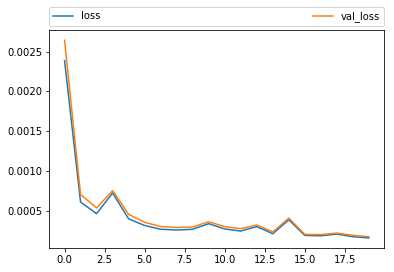

In [136]:
def test_toy():
    # %%
    # load MNIST as before
    
    ccae = inference()

    # %%
    learning_rate = 0.00005
    decay=0.0
    momentum=0.9
    epsilon=1e-08
    optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # %%
    # Fit all training data
    hist_train_loss = []
    hist_val_loss = []
    batch_size = 4
    n_epochs = 20
    for epoch_i in range(n_epochs):
        for batch_i in range(800 // batch_size):
            #batch_xs, _ = mnist.train.next_batch(batch_size)
            #train = np.array([img - mean_img for img in batch_xs])
            train = lr_vols_motion_cor[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.            
            motion = motion_field[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,:]
            
            #print train.shape, motion.shape
            sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 0.95})
        # Validation
        train_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        train = lr_vols_motion_cor[800:900,...,:10,np.newaxis]/100.            
        motion = motion_field[800:900,...,:10,:]     
        val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        
        hist_train_loss.append(train_loss)
        hist_val_loss.append(val_loss)
        print('Epoch',epoch_i)
        print('Train loss',train_loss, 'Val loss', val_loss)

    # %%
    plt.figure()
    plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
    # Plot example reconstructions
    n_examples = 10
    test_xs_norm = lr_vols_motion_cor[900:1000,...,:10,np.newaxis]/100.
            
    motion_test = motion_field[900:1000,...,:10,:]
            
    #test_xs, _ = mnist.test.next_batch(n_examples)
    #test_xs_norm = np.array([img - mean_img for img in test_xs])
    #test_xs_norm = np.reshape(test_xs,(n_examples,28,28,1))
    recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
    print(recon.shape)
    recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})
    '''
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(test_xs[example_i, :], (28, 28)))
        #axs[1][example_i].imshow(
        #    np.reshape(
        #        np.reshape(recon[example_i, ...], (784,)) + mean_img,
        #        (28, 28)))
        axs[1][example_i].imshow(
            recon[example_i, ...,0])
    fig.show()
    plt.draw()
    #plt.waitforbuttonpress()
    '''
    
    return [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss}]

results_data = test_toy()

('Epoch', 0)
('Train loss', 0.00021657422, 'Val loss', 0.00031537781)
('Epoch', 1)
('Train loss', 0.00020133838, 'Val loss', 0.00027743314)
('Epoch', 2)
('Train loss', 0.00017128226, 'Val loss', 0.00023351026)
('Epoch', 3)
('Train loss', 0.00014419499, 'Val loss', 0.00019962549)
('Epoch', 4)
('Train loss', 0.00013655785, 'Val loss', 0.00018639845)
('Epoch', 5)
('Train loss', 0.00011253349, 'Val loss', 0.00015398362)
('Epoch', 6)
('Train loss', 9.3521405e-05, 'Val loss', 0.00013048752)
('Epoch', 7)
('Train loss', 8.5646578e-05, 'Val loss', 0.00011829898)
('Epoch', 8)
('Train loss', 7.9867059e-05, 'Val loss', 0.00010812351)
('Epoch', 9)
('Train loss', 7.2922936e-05, 'Val loss', 9.889013e-05)
('Epoch', 10)
('Train loss', 6.5835076e-05, 'Val loss', 9.1232359e-05)
('Epoch', 11)
('Train loss', 5.8873029e-05, 'Val loss', 8.4057014e-05)
('Epoch', 12)
('Train loss', 6.0618455e-05, 'Val loss', 8.3440718e-05)
('Epoch', 13)
('Train loss', 5.7792327e-05, 'Val loss', 7.9239697e-05)
('Epoch', 14)
('T

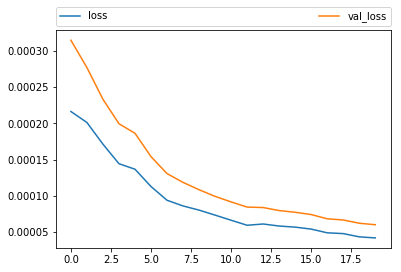

In [141]:
# train on oracle and images with motion

def test_toy():
    # %%
    # load MNIST as before
    
    ccae = inference()

    # %%
    learning_rate = 0.00005
    decay=0.
    momentum=0.9
    epsilon=1e-08
    optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # %%
    # Fit all training data
    hist_train_loss = []
    hist_val_loss = []
    batch_size = 1
    n_epochs = 20
    for epoch_i in range(n_epochs):
        for batch_i in range(800 // batch_size):
            #batch_xs, _ = mnist.train.next_batch(batch_size)
            #train = np.array([img - mean_img for img in batch_xs])
            train_oracle = lr_vols[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.            
            train = lr_vols_motion_cor[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.            
            motion = motion_field[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,:]
            
            #print train.shape, motion.shape
            # train oracle (denoising AE mode)
            sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: np.zeros_like(motion), ccae['t']: train_oracle, ccae['keep_prob']: 1.})           
            # train on motion image (Conditional AE)
            sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        # Validation
        train_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        train = lr_vols_motion_cor[800:900,...,:10,np.newaxis]/100.            
        motion = motion_field[800:900,...,:10,:]     
        val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        
        hist_train_loss.append(train_loss)
        hist_val_loss.append(val_loss)
        print('Epoch',epoch_i)
        print('Train loss',train_loss, 'Val loss', val_loss)
        
    plt.figure()
    plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

    # %%
    # Plot example reconstructions
    n_examples = 10
    test_xs_norm = lr_vols_motion_cor[900:1000,...,:10,np.newaxis]/100.
            
    motion_test = motion_field[900:1000,...,:10,:]
            
    #test_xs, _ = mnist.test.next_batch(n_examples)
    #test_xs_norm = np.array([img - mean_img for img in test_xs])
    #test_xs_norm = np.reshape(test_xs,(n_examples,28,28,1))
    recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
    print(recon.shape)
    recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})
    '''
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(test_xs[example_i, :], (28, 28)))
        #axs[1][example_i].imshow(
        #    np.reshape(
        #        np.reshape(recon[example_i, ...], (784,)) + mean_img,
        #        (28, 28)))
        axs[1][example_i].imshow(
            recon[example_i, ...,0])
    fig.show()
    plt.draw()
    #plt.waitforbuttonpress()
    '''
    
    return [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss}]

results_data = test_toy()

# 2 way AE

In [34]:

def inference_mocae(input_shape=[None, 22,22,10,1],
         input_shape_m=[None, 22,22,10,3],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build the fMRI model.

    Args:
    images: Images returned from distorted_inputs() or inputs().

    Returns:
    Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # %%
    
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    m = tf.placeholder(
        tf.float32, input_shape_m, name='m')
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)
    #keep_prob=1.
    ### BRANCH 3d images
    with tf.variable_scope('img_conv1_1') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, 1, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(x, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv2_3') as scope:
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    #current_input = resize_volumes(current_input, 2, 2, 2)
    
    # Max pooling
    #current_input = max_pool_2x2(current_input)

    '''
    with tf.variable_scope('img_deconv1') as scope:
        nfeaturemap = 512
        W = weight_variable([3, 3, 3, nfeaturemap, input_nfeaturemap])
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3], nfeaturemap]), 
                                        strides=[1, 2, 2, 2, 1], 
                                        padding='SAME',
                                       name='Deconvolution1')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    '''
    #current_input = tf.contrib.keras.layers.UpSampling3D(current_input, size=2)
    
    #'''
    branch_image = current_input

    ### BRANCH motion parameters
    with tf.variable_scope('motion_conv1_1') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, 3, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(m, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    
    # Max pooling
    #current_input = max_pool_2x2(current_input)
        
    with tf.variable_scope('motion_conv1_3') as scope:
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output

    branch_motion = current_input
    
    current_input = tf.concat([branch_image, branch_motion], axis=-1)
    #print tf.shape(current_input)[-1]
    input_nfeaturemap = 512
    #tf.shape(current_input)[-1]
    
    with tf.variable_scope('conv3_2') as scope:
        nfeaturemap = 256
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
    #'''    
    with tf.variable_scope('conv3_3') as scope:
        nfeaturemap = 512
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('conv3_4') as scope:
        nfeaturemap = 256
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        middle_branch_fmap = nfeaturemap
        middle_branch = output

    # Fan out branchs   
    with tf.variable_scope('image_out_conv1') as scope:
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, middle_branch_fmap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(middle_branch, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('image_out_conv2') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('image_out_conv') as scope:
        nfeaturemap = 1
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        image_output = conv3d(current_input, W) + b
    
    y=image_output
    
    with tf.variable_scope('motion_out_conv1') as scope:
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, middle_branch_fmap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(middle_branch, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_out_conv2') as scope:
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_out_conv') as scope:
        nfeaturemap = 3
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        motion_output = conv3d(current_input, W) + b
        
        



    # pool1
    #pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
    #                     padding='SAME', name='pool1')
    # norm1
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
    #                name='norm1')



    cost = tf.reduce_mean(tf.square(image_output - x)) + tf.reduce_mean(tf.square(motion_output - m))

    # %%
    return {'x': x, 'm': m, 'y': y, 'cost': cost, 'keep_prob': keep_prob}


In [33]:

def inference_mocae_samew(input_shape=[None, 22,22,10,1],
         input_shape_m=[None, 22,22,10,3],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build the fMRI model.

    Args:
    images: Images returned from distorted_inputs() or inputs().

    Returns:
    Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # %%
    
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    m = tf.placeholder(
        tf.float32, input_shape_m, name='m')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)
    
    encoder_i = []
    encoder_m = []
    encoder_main = []
    shapes_main = []
    shapes_i = []
    shapes_m = []
    
    #keep_prob=1.
    ### BRANCH 3d images
    with tf.variable_scope('img_conv1_1') as scope:
        shapes_i.append(x.get_shape().as_list())
        nfeaturemap = 256
        W = weight_variable([2, 2, 2, 1, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(x, W) + b)
        encoder_i.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv2_1') as scope:
        shapes_i.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_i.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv3_1') as scope:
        shapes_i.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_i.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    branch_image = current_input

    ### BRANCH motion parameters
    with tf.variable_scope('motion_conv1_1') as scope:
        shapes_m.append(m.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, 3, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(m, W) + b)
        encoder_m.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('motion_conv1_3') as scope:
        shapes_m.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_m.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
        
    with tf.variable_scope('motion_conv1_3') as scope:
        shapes_m.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_m.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output

    branch_motion = current_input
    
    #current_input = tf.concat([branch_image, branch_motion], axis=4)
    current_input = tf.multiply(branch_image,branch_motion)
    #print tf.shape(current_input)[-1]
    #input_nfeaturemap = 128
    #tf.shape(current_input)[-1]
    
    with tf.variable_scope('conv3_2') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
    #'''    
    with tf.variable_scope('conv3_3') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.tanh(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
        
    # store the latent representation
    z = current_input
    encoder_main.reverse()
    encoder_i.reverse()
    encoder_m.reverse()
    
    shapes_main.reverse()
    shapes_i.reverse()
    shapes_m.reverse()
    
        
    with tf.variable_scope('conv3_4') as scope:
        shapes = shapes_main[0]
        W = encoder_main[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(z, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        current_input = output
        
    with tf.variable_scope('conv3_5') as scope:
        shapes = shapes_main[1]
        W = encoder_main[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        middle_branch_fmap = nfeaturemap
        middle_branch = output
        
    #middle_branch_i , middle_branch_m = tf.split(middle_branch, num_or_size_splits=2, axis=4)

    # Fan out branchs   
    with tf.variable_scope('image_out_conv1') as scope:  
        shapes = shapes_i[0]
        W = encoder_i[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(middle_branch, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('image_out_conv2') as scope:
        shapes = shapes_i[1]
        W = encoder_i[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('image_out_conv') as scope:
        shapes = shapes_i[2]
        W = encoder_i[2]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        image_output = deconv + b
    
    y=image_output
    
    with tf.variable_scope('motion_out_conv1') as scope:
        shapes = shapes_m[0]
        W = encoder_m[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(middle_branch, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_out_conv2') as scope:
        shapes = shapes_m[1]
        W = encoder_m[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.tanh(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_out_conv') as scope:
        shapes = shapes_m[2]
        W = encoder_m[2]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        motion_output = deconv + b
        
        



    # pool1
    #pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
    #                     padding='SAME', name='pool1')
    # norm1
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
    #                name='norm1')



    cost = tf.reduce_mean(tf.square(x-image_output)) + tf.reduce_mean(tf.square(m-motion_output))

    # %%
    return {'x': x, 'm': m, 'y': y, 'cost': cost, 'keep_prob': keep_prob}


In [35]:

def inference_mocae_samew_small(input_shape=[None, 22,22,10,1],
         input_shape_m=[None, 22,22,10,3],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build the fMRI model.

    Args:
    images: Images returned from distorted_inputs() or inputs().

    Returns:
    Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # %%
    
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    m = tf.placeholder(
        tf.float32, input_shape_m, name='m')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)
    
    encoder_i = []
    encoder_m = []
    encoder_main = []
    shapes_main = []
    shapes_i = []
    shapes_m = []
    
    #keep_prob=1.
    ### BRANCH 3d images
    with tf.variable_scope('img_conv1_1') as scope:
        shapes_i.append(x.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([2, 2, 2, 1, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(x, W) + b)
        encoder_i.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv1_3') as scope:
        shapes_i.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_i.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    branch_image = current_input

    ### BRANCH motion parameters
    with tf.variable_scope('motion_conv1_1') as scope:
        shapes_m.append(m.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([2, 2, 2, 3, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(m, W) + b)
        encoder_m.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    #current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
        
    with tf.variable_scope('motion_conv1_3') as scope:
        shapes_m.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_m.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output

    branch_motion = current_input
    
    #current_input = tf.concat([branch_image, branch_motion], axis=4)
    #input_nfeaturemap = 128
    current_input = tf.multiply(branch_image,branch_motion)
    #print tf.shape(current_input)[-1]
    #tf.shape(current_input)[-1]
    
    with tf.variable_scope('conv3_1') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
    #'''    
    with tf.variable_scope('conv3_2') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
        
    # store the latent representation
    z = current_input
    encoder_main.reverse()
    encoder_i.reverse()
    encoder_m.reverse()
    
    shapes_main.reverse()
    shapes_i.reverse()
    shapes_m.reverse()
    
        
    with tf.variable_scope('deconv1_1') as scope:
        shapes = shapes_main[0]
        W = encoder_main[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(z, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        current_input = output
        
    with tf.variable_scope('deconv1_2') as scope:
        shapes = shapes_main[1]
        W = encoder_main[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        middle_branch_fmap = nfeaturemap
        middle_branch = output
        
    #middle_branch_i , middle_branch_m = tf.split(middle_branch, num_or_size_splits=2, axis=4)

    # Fan out branchs   
    with tf.variable_scope('image_out_deconv1') as scope:  
        shapes = shapes_i[0]
        W = encoder_i[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(middle_branch, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('image_out_deconv') as scope:
        shapes = shapes_i[1]
        W = encoder_i[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        image_output = deconv + b
    
    y=image_output
    
    with tf.variable_scope('motion_out_deconv1') as scope:
        shapes = shapes_m[0]
        W = encoder_m[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(middle_branch, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('motion_out_deconv') as scope:
        shapes = shapes_m[1]
        W = encoder_m[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        motion_output = deconv + b
        
        



    # pool1
    #pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
    #                     padding='SAME', name='pool1')
    # norm1
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
    #                name='norm1')



    cost = tf.reduce_mean(tf.square(x-image_output)) + tf.reduce_mean(tf.square(m-motion_output))

    # %%
    return {'x': x, 'm': m, 'y': y, 'cost': cost, 'keep_prob': keep_prob}


In [17]:

def inference_mocae_samew_supercompact(input_shape=[None, 22,22,10,1],
         input_shape_m=[None, 22,22,10,3],
                n_filters=[1, 32, 32, 32],
                filter_sizes=[3, 2, 3, 2],
                corruption=False):
    """Build the fMRI model.

    Args:
    images: Images returned from distorted_inputs() or inputs().

    Returns:
    Logits.
    """
    # We instantiate all variables using tf.get_variable() instead of
    # tf.Variable() in order to share variables across multiple GPU training runs.
    # If we only ran this model on a single GPU, we could simplify this function
    # by replacing all instances of tf.get_variable() with tf.Variable().
    #
    # %%
    
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    m = tf.placeholder(
        tf.float32, input_shape_m, name='m')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)
    
    encoder_i = []
    encoder_m = []
    encoder_main = []
    shapes_main = []
    shapes_i = []
    shapes_m = []
    
    current_input = tf.concat([x, m], axis=4)
    input_nfeaturemap = 4
    #keep_prob=1.
    ### BRANCH 3d images
    with tf.variable_scope('img_conv1_1') as scope:
        shapes_main.append(current_input.get_shape().as_list())#x.get_shape().as_list())
        nfeaturemap = 32
        W = weight_variable([3, 3, 3, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('img_conv1_3') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 64
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
    
    #current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    '''
    with tf.variable_scope('img_conv1_3') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
    '''    
    #current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    
    with tf.variable_scope('conv3_1') as scope:
        shapes_main.append(current_input.get_shape().as_list())
        nfeaturemap = 128
        W = weight_variable([1, 1, 1, input_nfeaturemap, nfeaturemap])
        b = bias_variable([nfeaturemap])
        output = tf.nn.relu(conv3d(current_input, W) + b)
        encoder_main.append(W)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
        
    # store the latent representation
    z = current_input
    encoder_main.reverse() 
    shapes_main.reverse()
    
        
    with tf.variable_scope('deconv1_1') as scope:
        shapes = shapes_main[0]
        W = encoder_main[0]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(z, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    with tf.variable_scope('deconv1_2') as scope:
        shapes = shapes_main[1]
        W = encoder_main[1]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    #middle_branch_i , middle_branch_m = tf.split(middle_branch, num_or_size_splits=2, axis=4)
    '''
    # Fan out branchs   
    with tf.variable_scope('image_out_deconv1') as scope:  
        shapes = shapes_main[2]
        W = encoder_main[2]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(middle_branch, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        output = tf.nn.relu(deconv + b)
        input_nfeaturemap = nfeaturemap
        current_input = output
        
    current_input = tf.nn.dropout(current_input, keep_prob, [tf.shape(x)[0],1,1,1,input_nfeaturemap])
    '''
    with tf.variable_scope('image_out_deconv') as scope:
        shapes = shapes_main[2]
        W = encoder_main[2]
        nfeaturemap = W.get_shape().as_list()[-2]
        b = bias_variable([nfeaturemap])
        deconv = tf.nn.conv3d_transpose(current_input, 
                                        W, 
                                        output_shape=tf.stack([tf.shape(x)[0], shapes[1], shapes[2], shapes[3], shapes[4]]), 
                                        strides=[1, 1, 1, 1, 1], 
                                        padding='SAME')
        image_output = deconv + b
    
    y_hat , m_hat = tf.split(image_output, num_or_size_splits=[1,3], axis=4)

    y=y_hat

    
    cost = tf.reduce_mean(tf.square(x-y)) + tf.reduce_mean(tf.square(m-m_hat))

    # %%
    return {'x': x, 'm': m, 'y': y, 'cost': cost, 'keep_prob': keep_prob}


In [229]:
a=lr_vols_motion_cor[1:10,...,:10,np.newaxis]/100.            
b=(lr_vols_motion_cor[1:10,...,:10,np.newaxis]/100.).mean(0)         
(a-b).shape

(9, 22, 22, 10, 1)

In [130]:
def ts_vec2vol(vec, mask):
    vol = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],vec.shape[0]))
    vol[mask] = vec.T
    vol = np.swapaxes(vol[np.newaxis,...],0,-1)[...,0]
    return vol
    
def ts_vol2vec(vol, mask):
    return np.swapaxes(vol[...,np.newaxis],0,-1)[0,...][mask].T


import statsmodels.api as sm

def mass_univar_reg(y, X, intercept=True):
    if len(y.shape)==1:
        y = y[:,np.newaxis]
   
    n_ = y.shape[1]
    if intercept:
        X = sm.add_constant(X)
        
    res = []
    for ii in range(n_):
        result = sm.OLS(y[:,ii],X).fit()
        if intercept:
            res.append(result.resid + result.params[0])
        else:
            res.append(result.resid)
        #print result.beta
        #print result.params[0]
        #print result.summary()
        
    return np.array(res).T

def corrmap(image1,image2):
    cor_map = np.zeros((image1.shape[1],image1.shape[2]))
    for ii in range(image1.shape[1]):
        for jj in range(image1.shape[2]):
            cor_map[ii,jj] = np.corrcoef(image1[:,ii,jj],image2[:,ii,jj])[0,1]
    return cor_map

def corrmap3D(image1,image2):
    #cor_map = np.zeros((image1.shape[1],image1.shape[2]))
    
    mask = np.ones_like(image1[0,...]).astype(bool)
    vec1 = ts_vol2vec(image1,mask)
    vec2 = ts_vol2vec(image2,mask)
    vec_corr = [np.corrcoef(vec1[:,ii],vec2[:,ii])[0,1] for ii in range(vec1.shape[1])]
    vol_corr = ts_vec2vol(np.array(vec_corr)[np.newaxis,...],mask)
    return vol_corr

('Epoch', 0)
('Train loss', 0.55588698, 'Val loss', 0.58835584, 'Ref loss', 0.026544644)
('Epoch', 1)
('Train loss', 0.29259428, 'Val loss', 0.31363189, 'Ref loss', 0.015262236)
('Epoch', 2)
('Train loss', 0.17165238, 'Val loss', 0.19116771, 'Ref loss', 0.011979388)
('Epoch', 3)
('Train loss', 0.12169705, 'Val loss', 0.14016044, 'Ref loss', 0.0097575104)
('Epoch', 4)
('Train loss', 0.096792512, 'Val loss', 0.11231805, 'Ref loss', 0.0082884915)
('Epoch', 5)
('Train loss', 0.08068499, 'Val loss', 0.094782874, 'Ref loss', 0.0076541891)
('Epoch', 6)
('Train loss', 0.069436461, 'Val loss', 0.081642181, 'Ref loss', 0.0069138445)
('Epoch', 7)
('Train loss', 0.061466072, 'Val loss', 0.072051577, 'Ref loss', 0.0065143965)
('Epoch', 8)
('Train loss', 0.055280745, 'Val loss', 0.064259671, 'Ref loss', 0.0062523838)
('Epoch', 9)
('Train loss', 0.049877312, 'Val loss', 0.057721034, 'Ref loss', 0.0063157771)
('Epoch', 10)
('Train loss', 0.045200039, 'Val loss', 0.051873337, 'Ref loss', 0.0060720053)


('Epoch', 88)
('Train loss', 0.0038639756, 'Val loss', 0.0047470252, 'Ref loss', 0.003003235)
('Epoch', 89)
('Train loss', 0.0038149571, 'Val loss', 0.0047048335, 'Ref loss', 0.0030087498)
('Epoch', 90)
('Train loss', 0.0039650169, 'Val loss', 0.0048027756, 'Ref loss', 0.0029494013)
('Epoch', 91)
('Train loss', 0.0037485128, 'Val loss', 0.0046073375, 'Ref loss', 0.002948862)
('Epoch', 92)
('Train loss', 0.0038182624, 'Val loss', 0.0046899347, 'Ref loss', 0.0029591261)
('Epoch', 93)
('Train loss', 0.0037094317, 'Val loss', 0.0045383149, 'Ref loss', 0.0029084219)
('Epoch', 94)
('Train loss', 0.0036882067, 'Val loss', 0.0044891881, 'Ref loss', 0.0028640912)
('Epoch', 95)
('Train loss', 0.0036441102, 'Val loss', 0.0044318852, 'Ref loss', 0.0028848536)
('Epoch', 96)
('Train loss', 0.003662671, 'Val loss', 0.0044452557, 'Ref loss', 0.0030355277)
('Epoch', 97)
('Train loss', 0.0035513577, 'Val loss', 0.0043557198, 'Ref loss', 0.0028714114)
('Epoch', 98)
('Train loss', 0.0035494671, 'Val loss'

('Epoch', 174)
('Train loss', 0.002082481, 'Val loss', 0.0025463272, 'Ref loss', 0.0026710995)
('Epoch', 175)
('Train loss', 0.002063944, 'Val loss', 0.0025239766, 'Ref loss', 0.0026591383)
('Epoch', 176)
('Train loss', 0.0021171358, 'Val loss', 0.0025490713, 'Ref loss', 0.0025975876)
('Epoch', 177)
('Train loss', 0.0021018109, 'Val loss', 0.0025527778, 'Ref loss', 0.0026171203)
('Epoch', 178)
('Train loss', 0.0020181409, 'Val loss', 0.002472955, 'Ref loss', 0.0026070247)
('Epoch', 179)
('Train loss', 0.0020763087, 'Val loss', 0.0025298595, 'Ref loss', 0.0026003544)
('Epoch', 180)
('Train loss', 0.0021198452, 'Val loss', 0.0025215505, 'Ref loss', 0.0027610462)
('Epoch', 181)
('Train loss', 0.002025655, 'Val loss', 0.0024644502, 'Ref loss', 0.002574665)
('Epoch', 182)
('Train loss', 0.0020403089, 'Val loss', 0.0024536073, 'Ref loss', 0.0026523222)
('Epoch', 183)
('Train loss', 0.0020362635, 'Val loss', 0.0024452377, 'Ref loss', 0.0026154886)
('Epoch', 184)
('Train loss', 0.0020640623, '

('Epoch', 260)
('Train loss', 0.0013380086, 'Val loss', 0.0017066774, 'Ref loss', 0.0026167927)
('Epoch', 261)
('Train loss', 0.0013522403, 'Val loss', 0.0017181549, 'Ref loss', 0.0025307811)
('Epoch', 262)
('Train loss', 0.0013582043, 'Val loss', 0.0017084372, 'Ref loss', 0.0025332717)
('Epoch', 263)
('Train loss', 0.0013236287, 'Val loss', 0.0016892338, 'Ref loss', 0.0025057695)
('Epoch', 264)
('Train loss', 0.0013147447, 'Val loss', 0.0016860871, 'Ref loss', 0.0025785426)
('Epoch', 265)
('Train loss', 0.0013510783, 'Val loss', 0.0017106133, 'Ref loss', 0.0026098657)
('Epoch', 266)
('Train loss', 0.0013172969, 'Val loss', 0.0016962233, 'Ref loss', 0.0025585413)
('Epoch', 267)
('Train loss', 0.0014506623, 'Val loss', 0.0017701741, 'Ref loss', 0.0027856801)
('Epoch', 268)
('Train loss', 0.0013180829, 'Val loss', 0.0016627482, 'Ref loss', 0.002548218)
('Epoch', 269)
('Train loss', 0.0012894542, 'Val loss', 0.0016464558, 'Ref loss', 0.0025256628)
('Epoch', 270)
('Train loss', 0.001288257

('Epoch', 346)
('Train loss', 0.00098938029, 'Val loss', 0.0012972791, 'Ref loss', 0.0024989727)
('Epoch', 347)
('Train loss', 0.0009947744, 'Val loss', 0.0012899698, 'Ref loss', 0.0025149465)
('Epoch', 348)
('Train loss', 0.0010325714, 'Val loss', 0.0013341083, 'Ref loss', 0.0024324059)
('Epoch', 349)
('Train loss', 0.00095542299, 'Val loss', 0.001264404, 'Ref loss', 0.002438724)
('Epoch', 350)
('Train loss', 0.0009657396, 'Val loss', 0.0012768209, 'Ref loss', 0.0025084873)
('Epoch', 351)
('Train loss', 0.00096409122, 'Val loss', 0.001260499, 'Ref loss', 0.0024781134)
('Epoch', 352)
('Train loss', 0.0009654485, 'Val loss', 0.0012812088, 'Ref loss', 0.0024385375)
('Epoch', 353)
('Train loss', 0.00099838141, 'Val loss', 0.0012990988, 'Ref loss', 0.0024399208)
('Epoch', 354)
('Train loss', 0.00095973536, 'Val loss', 0.0012625837, 'Ref loss', 0.0025469593)
('Epoch', 355)
('Train loss', 0.00092978426, 'Val loss', 0.0012379815, 'Ref loss', 0.0024936479)
('Epoch', 356)
('Train loss', 0.00098

('Epoch', 431)
('Train loss', 0.00085249357, 'Val loss', 0.0011020924, 'Ref loss', 0.0025055415)
('Epoch', 432)
('Train loss', 0.00076768734, 'Val loss', 0.0010304515, 'Ref loss', 0.0024684693)
('Epoch', 433)
('Train loss', 0.00076420215, 'Val loss', 0.0010348214, 'Ref loss', 0.0024825034)
('Epoch', 434)
('Train loss', 0.00079075515, 'Val loss', 0.0010504478, 'Ref loss', 0.0024938704)
('Epoch', 435)
('Train loss', 0.0008136963, 'Val loss', 0.0010843941, 'Ref loss', 0.0024051359)
('Epoch', 436)
('Train loss', 0.00079966872, 'Val loss', 0.0010558984, 'Ref loss', 0.0024639426)
('Epoch', 437)
('Train loss', 0.00077503506, 'Val loss', 0.0010350555, 'Ref loss', 0.0025219829)
('Epoch', 438)
('Train loss', 0.000819629, 'Val loss', 0.0010792654, 'Ref loss', 0.0024616872)
('Epoch', 439)
('Train loss', 0.0007687675, 'Val loss', 0.0010365886, 'Ref loss', 0.0024013587)
('Epoch', 440)
('Train loss', 0.0007433421, 'Val loss', 0.0010080914, 'Ref loss', 0.0024362437)
('Epoch', 441)
('Train loss', 0.000

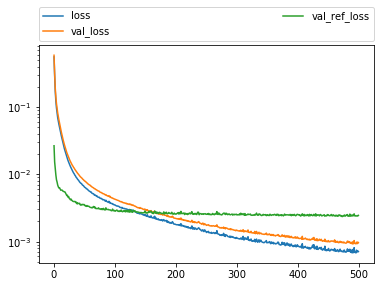

In [454]:
# %%
%run models/mocae.py
%run models/fconv_encoder.py

#ccae = inference_mocae()# multi-objective convolutional auto encoder
#ccae = inference_mocae_mul() # same w for encoder end decoder

#ccae = inference_fconv_small12()
ccae = inference_fconv()
#ccae = inference_fconv_supercompact()
#ccae = inference_mocae_mul()
#ccae = inference_mocae_multibranch()
#ccae = inference_mocae_concat()
#ccae = inference_2obj()
# %%
learning_rate = 0.000001
#learning_rate = 0.00001
decay=0.
momentum=0.9
epsilon=1e-08
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])
#optimizer_i = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_i'])
#optimizer_m = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_m'])


#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(ccae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# %%
# Fit all training data
hist_train_loss = []
hist_val_loss = []
hist_val_ref_loss = []
batch_size = 3
n_epochs = 500
mean_data = (lr_vols_motion_cor[...,:10,np.newaxis]/100.).mean(0) 
mean_target = (lr_vols[...,:10,np.newaxis]/100.).mean(0) 
for epoch_i in range(n_epochs):
    for batch_i in range(800 // batch_size):
        #batch_xs, _ = mnist.train.next_batch(batch_size)
        #train = np.array([img - mean_img for img in batch_xs])
        target = lr_vols[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.
        train = lr_vols_motion_cor[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.            
        #target -= mean_target
        #train -= mean_data
        motion = motion_field[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,:]

        #print train.shape, motion.shape
        sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: .8})
        #sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})
        
    # Validation
    #train = lr_vols_motion_cor[0:(799+1)*batch_size,...,:10,np.newaxis]/100.            
    #motion = motion_field[0:(799+1)*batch_size,...,:10,:]

    train_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
    train = lr_vols_motion_cor[800:900,...,:10,np.newaxis]/100.  
    #train -= mean_data
    motion = motion_field[800:900,...,:10,:]     
    val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})

    target = lr_vols[800:900,...,:10,np.newaxis]/100.
    #target -= mean_target
    #val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: np.zeros_like(motion), ccae['t']: target, ccae['keep_prob']: 1.})
    val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})

    hist_val_ref_loss.append(val_ref_loss)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    print('Epoch',epoch_i)
    print('Train loss',train_loss, 'Val loss', val_loss, 'Ref loss', val_ref_loss)

# %%
plt.figure()
ax=plt.subplot(111)
plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss,range(n_epochs),hist_val_ref_loss )
plt.legend(['loss','val_loss', 'val_ref_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
   ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')
# Plot example reconstructions
n_examples = 10
test_xs_norm = lr_vols_motion_cor[900:1000,...,:10,np.newaxis]/100.
motion_test = motion_field[900:1000,...,:10,:]

#test_xs, _ = mnist.test.next_batch(n_examples)
#test_xs_norm = np.array([img - mean_img for img in test_xs])
#test_xs_norm = np.reshape(test_xs,(n_examples,28,28,1))
recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
print(recon.shape)
recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})

# Close the Session when we're done.
#sess.close()

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

In [401]:
train = lr_vols_motion_cor[800:900,...,:10,np.newaxis]/100.  
    #train -= mean_data
motion = motion_field[800:900,...,:10,:]     
val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})

target = lr_vols[800:900,...,:10,np.newaxis]/100.
#target -= mean_target
#val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: np.zeros_like(motion), ccae['t']: target, ccae['keep_prob']: 1.})
val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})
val_ref_loss

0.002613632

In [ ]:
recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})


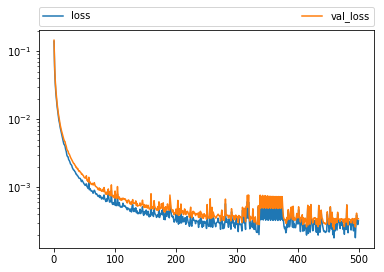

In [239]:
plt.figure()
epochs=500
ax=plt.subplot(111)
plt.plot(range(epochs),results_data[3]['train_loss'],range(epochs),results_data[3]['val_loss'])
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')



(768, 150)


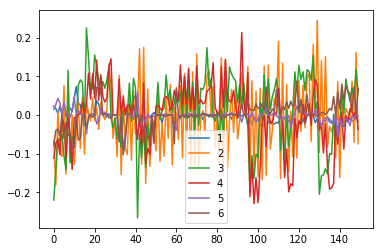

In [162]:
### Linear test subject 
import pandas as pd
reload(simu3d)
motion_s1 = pd.read_csv('/home_sq/cdansereau/data/cobre/cobre_ln_cor/HC/0040014/motion_params.csv',index_col=0)
plt.plot(motion_s1)
plt.legend(np.arange(1,7))
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
sim_s1 = simu3d.gen_sim(ref_vol, v2w, motion_s1.values)

(768, 150)


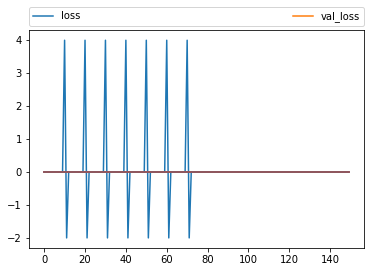

In [378]:
### Peek simulation
import pandas as pd
reload(simu3d)
motion_s1 = pd.read_csv('/home_sq/cdansereau/data/cobre/cobre_ln_cor/HC/0040014/motion_params.csv',index_col=0)
motion_s1 = motion_s1.values
motion_s1 = np.zeros_like(motion_s1)
motion_s1[[10,20,30,40,50,60,70],0] = 4.
motion_s1[[11,21,31,41,51,61,71],0] = -2.
plt.plot(motion_s1)
plt.legend(np.arange(1,7))
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
sim_s2 = simu3d.gen_sim(ref_vol, v2w, motion_s1)


In [455]:
def compute_corr3D(target, lr_vols_motion_cor, motion_params):
    
    #target -= mean_target[np.newaxis,...,0]
    #lr_vols_motion_cor -= mean_data[np.newaxis,...,0]
    
    # create displacement field
    motion_field = registration.displacement_field(np.eye(4),motion_params, target.shape[1:])%3.

    # compute deepmotion correction
    recon = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: motion_field, ccae['keep_prob']: 1.})
    recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: np.zeros_like(motion_field), ccae['keep_prob']: 1.})
    
    results_data = []
    results_data.append(lr_vols_motion_cor)
    results_data.append(recon[...,0])
    results_data.append(recon_cor[...,0])
    
    # regress out the motion  
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    mask = (cor_map_ref==1)[0,...]
    residual = mass_univar_reg(ts_vol2vec(lr_vols_motion_cor,mask), simu3d.vexpension(motion_params))
    vol_motion_lincor = ts_vec2vol(residual,mask)
    
    # compute the correlations
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    cor_map_lin = np.nan_to_num(corrmap3D(target,results_data[0]))
    cor_map_deep = np.nan_to_num(corrmap3D(target,results_data[1]))
    cor_map_lin_deep = np.nan_to_num(corrmap3D(results_data[0],results_data[1]))
    cor_map_zerom = np.nan_to_num(corrmap3D(target,results_data[2]))
    cor_map_lin_mparam_cor = np.nan_to_num(corrmap3D(target,vol_motion_lincor))
    
    # print the results
    print 'REF:',cor_map_ref[cor_map_ref!=0].mean(),cor_map_ref[cor_map_ref!=0].std()
    print 'cor_map_lin:',cor_map_lin[cor_map_ref!=0].mean(),cor_map_lin[cor_map_ref!=0].std()
    print 'cor_map_deep:',cor_map_deep[cor_map_ref!=0].mean(),cor_map_deep[cor_map_ref!=0].std()
    print 'cor_map_lin_deep:',cor_map_lin_deep[cor_map_ref!=0].mean(),cor_map_lin_deep[cor_map_ref!=0].std()
    print 'cor_map_zerom:',cor_map_zerom[cor_map_ref!=0].mean(),cor_map_zerom[cor_map_ref!=0].std()
    print 'cor_map_lin_mparam_cor:', cor_map_lin_mparam_cor[cor_map_ref!=0].mean(),cor_map_lin_mparam_cor[cor_map_ref!=0].std()
    
    return {'cor_map_ref':cor_map_ref, 
            'cor_map_lin':cor_map_lin, 
            'cor_map_deep':cor_map_deep, 
            'cor_map_lin_deep':cor_map_lin_deep, 
            'cor_map_zerom':cor_map_zerom, 
            'cor_map_lin_mparam_cor':cor_map_lin_mparam_cor,
            'vol_motion':results_data[0],
            'vol_motion_deep':results_data[1],
            'vol_motion_deepcor':results_data[2],
            'vol_motion_lincor':vol_motion_lincor,
            'target':target}
    
res_stats = compute_corr3D(lr_vols[-100:,...,:10]/100.,
              lr_vols_motion_cor[-100:,...,:10]/100.,
              motion_params[-100:,:])

res_stats = compute_corr3D(sim_s2['lr_vols'][...,:10]/100.,
              sim_s2['lr_vols_motion_cor'][...,:10]/100.,
              sim_s2['motion_params'])

res_stats = compute_corr3D(sim_s1['lr_vols'][...,:10]/100.,
              sim_s1['lr_vols_motion_cor'][...,:10]/100.,
              sim_s1['motion_params'])



REF: 1.0 1.16441173167e-16
cor_map_lin: 0.718795647233 0.222479016951
cor_map_deep: 0.391459913615 0.217350913175
cor_map_lin_deep: 0.598924897547 0.215500619808
cor_map_zerom: 0.78654324126 0.192216095203
cor_map_lin_mparam_cor: 0.361386085487 0.377981530862
REF: 1.0 8.10792259265e-17
cor_map_lin: 0.767274187166 0.18967306399
cor_map_deep: -0.101213313094 0.0194986285998
cor_map_lin_deep: -0.0554198502706 0.0880163709882
cor_map_zerom: 0.907456768527 0.0994343239968
cor_map_lin_mparam_cor: 0.0615040729621 0.177976763654
REF: 1.0 8.5997505699e-17
cor_map_lin: 0.742841015337 0.205114559227
cor_map_deep: 0.138801950341 0.105627427158
cor_map_lin_deep: 0.189932631998 0.118046239553
cor_map_zerom: 0.861116702446 0.146466598331
cor_map_lin_mparam_cor: 0.51826596827 0.365509811046


In [386]:
res_stats = compute_corr3D(sim_s2['lr_vols'][...,:10]/100.,
              sim_s2['lr_vols_motion_cor'][...,:10]/100.,
              sim_s2['motion_params'])

REF: 1.0 8.10792259265e-17
cor_map_lin: 0.767274187166 0.18967306399
cor_map_deep: -0.0910958682762 0.0226415602894
cor_map_lin_deep: -0.0489886877382 0.088557949671
cor_map_zerom: 0.942924453572 0.0719709975225
cor_map_lin_mparam_cor: 0.0615040729621 0.177976763654


In [323]:
# fconv small is working 

res_stats = compute_corr3D(lr_vols[-100:,...,:10]/100.,
              lr_vols_motion_cor[-100:,...,:10]/100.,
              motion_params[-100:,:])

res_stats = compute_corr3D(sim_s1['lr_vols'][...,:10]/100.,
              sim_s1['lr_vols_motion_cor'][...,:10]/100.,
              sim_s1['motion_params'])

REF: 1.0 1.16441173167e-16
cor_map_lin: 0.718795647233 0.222479016951
cor_map_deep: 0.538889114554 0.194134154383
cor_map_lin_deep: 0.707183096135 0.159781023211
cor_map_zerom: 0.846684938653 0.152270715076
cor_map_lin_mparam_cor: 0.361386085487 0.377981530862
REF: 1.0 8.5997505699e-17
cor_map_lin: 0.742841015337 0.205114559227
cor_map_deep: 0.187211291881 0.142543209242
cor_map_lin_deep: 0.244227910482 0.154260973254
cor_map_zerom: 0.918818274435 0.0947253020579
cor_map_lin_mparam_cor: 0.51826596827 0.365509811046


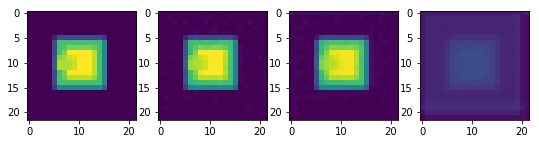

In [456]:
plt.figure(figsize=(9,3))
plt.subplot(1,4,1)
plt.imshow(res_stats['target'][10,:,:,5],interpolation='None')
plt.subplot(1,4,2)
plt.imshow(res_stats['vol_motion'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,3)
plt.imshow(res_stats['vol_motion_deep'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(res_stats['vol_motion_deepcor'][10,:,:,5],interpolation='None',vmin=0, vmax=1)


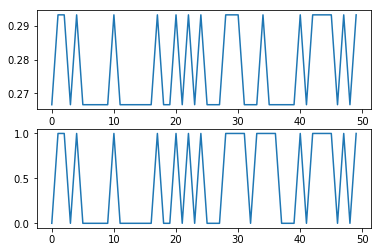

In [457]:
plt.subplot(211)
plt.plot(res_stats['target'][:50,10,5,5])
plt.subplot(212)
plt.plot(res_stats['vol_motion_deepcor'][:50,10,5,5]>res_stats['vol_motion_deepcor'][:,10,5,5].mean())

0.069416463

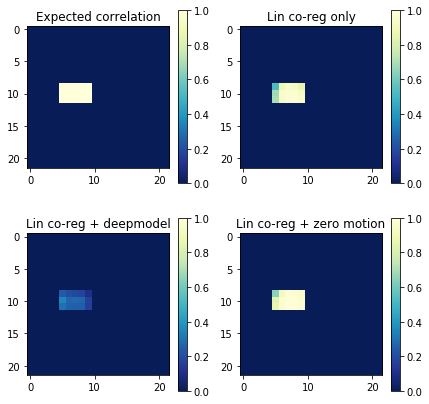

In [458]:
plt.figure(figsize=(7,7))
plt.subplot(221)
plt.title('Expected correlation')
plt.imshow(res_stats['cor_map_ref'][0,...,5],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()
plt.subplot(222)
plt.title('Lin co-reg only')
plt.imshow(res_stats['cor_map_lin'][0,...,5],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()
plt.subplot(223)
plt.title('Lin co-reg + deepmodel')
plt.imshow(res_stats['cor_map_deep'][0,...,5],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

plt.subplot(224)
plt.title('Lin co-reg + zero motion')
plt.imshow(res_stats['cor_map_zerom'][0,...,5],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

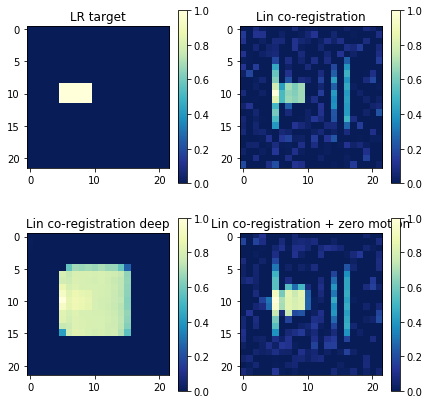

In [459]:
def get_seed_cor_map(vols, mask_roi=[]):
    # seed
    if mask_roi != []:
        seed = ts_vol2vec(vols,mask_roi).mean(1)[:,np.newaxis]
    else:
        seed = vols[:,10,5,5,np.newaxis]
        
    time_series = np.hstack((seed,vols[...,5].reshape((vols.shape[0],vols.shape[1]*vols.shape[2])))).T
    cor_map_ = np.corrcoef(time_series)[0,1:].reshape((vols.shape[1],vols.shape[2]))
    return cor_map_

plt.figure(figsize=(7,7))
cor_map_ = get_seed_cor_map(res_stats['target'])
plt.subplot(2,2,1)
plt.title('LR target')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion'])
plt.subplot(2,2,2)
plt.title('Lin co-registration')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion_deep'])
plt.subplot(2,2,3)
plt.title('Lin co-registration deep')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion_deepcor'])
plt.subplot(2,2,4)
plt.title('Lin co-registration + zero motion')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()


#lr_vols_motion_cor[-100:,...,5]

/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


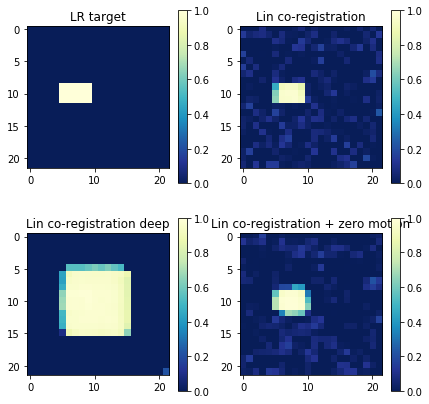

In [453]:



plt.figure(figsize=(7,7))
cor_map_ = get_seed_cor_map(res_stats['target'],mask_roi=res_stats['cor_map_ref'][0,...]==1)
plt.subplot(2,2,1)
plt.title('LR target')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion'],mask_roi=res_stats['cor_map_ref'][0,...]==1)
plt.subplot(2,2,2)
plt.title('Lin co-registration')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion_deep'],mask_roi=res_stats['cor_map_ref'][0,...]==1)
plt.subplot(2,2,3)
plt.title('Lin co-registration deep')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

cor_map_ = get_seed_cor_map(res_stats['vol_motion_deepcor'],mask_roi=res_stats['cor_map_ref'][0,...]==1)
plt.subplot(2,2,4)
plt.title('Lin co-registration + zero motion')
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()


#lr_vols_motion_cor[-100:,...,5]

In [74]:
# Conditional GAN

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim_g = 126
h_dim = 512

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim_g]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim_g]))

G_W2 = tf.Variable(xavier_init([h_dim_g, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iter: 0
D loss: 1.636
G_loss: 3.802
()
Iter: 1000
D loss: 0.0008492
G_loss: 12.46
()
Iter: 2000
D loss: 0.001515
G_loss: 8.875
()
Iter: 3000
D loss: 0.01361
G_loss: 7.464
()
Iter: 4000
D loss: 0.01548
G_loss: 8.086
()
Iter: 5000
D loss: 0.1033
G_loss: 6.862
()
Iter: 6000
D loss: 0.1906
G_loss: 5.38
()
Iter: 7000
D loss: 0.2317
G_loss: 5.339
()
Iter: 8000
D loss: 0.4034
G_loss: 3.949
()
Iter: 9000
D loss: 0.2111
G_loss: 4.796
()
Iter: 10000
D loss: 0.2945
G_loss: 3.911
()
Iter: 11000
D loss: 0.354
G_loss: 3.361
()
Iter: 12000
D loss: 0.3026
G_loss: 4.356
()
Iter: 13000
D loss: 0.3527
G_loss: 4.343
()
Iter: 14000
D loss: 0.3231
G_loss: 3.706
()
Iter: 15000
D loss: 0.4145
G_loss: 2.996
()
Iter: 16000
D loss: 0.6481
G_loss: 3.155
()
Iter: 17000
D loss: 0.4671
G_loss: 2.88
()
Iter: 18000
D loss: 0.53

Iter: 181000
D loss: 0.1046
G_loss: 4.851
()
Iter: 182000
D loss: 0.2723
G_loss: 4.93
()
Iter: 183000
D loss: 0.1035
G_loss: 5.617
()
Iter: 184000
D loss: 0.1892
G_loss: 5.48
()
Iter: 185000
D loss: 0.2858
G_loss: 5.23
()
Iter: 186000
D loss: 0.1524
G_loss: 5.297
()
Iter: 187000
D loss: 0.1885
G_loss: 4.942
()
Iter: 188000
D loss: 0.2361
G_loss: 4.949
()
Iter: 189000
D loss: 0.1086
G_loss: 5.386
()
Iter: 190000
D loss: 0.2204
G_loss: 5.25
()
Iter: 191000
D loss: 0.1433
G_loss: 6.007
()
Iter: 192000
D loss: 0.1359
G_loss: 5.54
()
Iter: 193000
D loss: 0.175
G_loss: 5.084
()
Iter: 194000
D loss: 0.1562
G_loss: 5.939
()
Iter: 195000
D loss: 0.1735
G_loss: 6.145
()
Iter: 196000
D loss: 0.1605
G_loss: 5.501
()
Iter: 197000
D loss: 0.1183
G_loss: 5.262
()
Iter: 198000
D loss: 0.1278
G_loss: 5.938
()
Iter: 199000
D loss: 0.2457
G_loss: 5.44
()
Iter: 200000
D loss: 0.2271
G_loss: 5.449
()
Iter: 201000
D loss: 0.2416
G_loss: 5.184
()
Iter: 202000
D loss: 0.06746
G_loss: 5.767
()
Iter: 203000
D l

Iter: 361000
D loss: 0.003715
G_loss: 12.32
()
Iter: 362000
D loss: 0.06818
G_loss: 12.54
()
Iter: 363000
D loss: 0.03162
G_loss: 24.21
()
Iter: 364000
D loss: 0.4699
G_loss: 19.54
()
Iter: 365000
D loss: 0.006673
G_loss: 31.35
()
Iter: 366000
D loss: 0.0004442
G_loss: 15.37
()
Iter: 367000
D loss: 0.02978
G_loss: 15.45
()
Iter: 368000
D loss: 0.00496
G_loss: 27.34
()
Iter: 369000
D loss: 0.07625
G_loss: 10.92
()
Iter: 370000
D loss: 0.02363
G_loss: 16.93
()
Iter: 371000
D loss: 0.0187
G_loss: 15.24
()
Iter: 372000
D loss: 0.00288
G_loss: 15.11
()
Iter: 373000
D loss: 0.0164
G_loss: 41.78
()
Iter: 374000
D loss: 0.002643
G_loss: 13.46
()
Iter: 375000
D loss: 0.001562
G_loss: 35.28
()
Iter: 376000
D loss: 0.03869
G_loss: 13.31
()
Iter: 377000
D loss: 0.02124
G_loss: 9.835
()
Iter: 378000
D loss: 0.0008752
G_loss: 12.41
()
Iter: 379000
D loss: 0.07192
G_loss: 11.77
()
Iter: 380000
D loss: 0.008386
G_loss: 19.24
()
Iter: 381000
D loss: 0.01144
G_loss: 34.91
()
Iter: 382000
D loss: 0.06762

Iter: 536000
D loss: 1.136e-05
G_loss: 24.13
()
Iter: 537000
D loss: 6.147e-05
G_loss: 32.03
()
Iter: 538000
D loss: 8.019e-05
G_loss: 20.5
()
Iter: 539000
D loss: 0.000322
G_loss: 20.35
()
Iter: 540000
D loss: 0.002671
G_loss: 15.02
()
Iter: 541000
D loss: 7.731e-05
G_loss: 20.67
()
Iter: 542000
D loss: 3.567e-09
G_loss: 54.69
()
Iter: 543000
D loss: 0.0001562
G_loss: 21.74
()
Iter: 544000
D loss: 0.0001254
G_loss: 18.82
()
Iter: 545000
D loss: 1.46e-05
G_loss: 27.38
()
Iter: 546000
D loss: 0.0006095
G_loss: 18.89
()
Iter: 547000
D loss: 0.0007549
G_loss: 24.92
()
Iter: 548000
D loss: 6.426e-06
G_loss: 23.84
()
Iter: 549000
D loss: 4.042e-05
G_loss: 34.25
()
Iter: 550000
D loss: 8.65e-06
G_loss: 32.85
()
Iter: 551000
D loss: 3.922e-06
G_loss: 45.8
()
Iter: 552000
D loss: 3.04e-05
G_loss: 50.38
()
Iter: 553000
D loss: 3.969e-07
G_loss: 36.17
()
Iter: 554000
D loss: 0.003769
G_loss: 13.69
()
Iter: 555000
D loss: 2.662e-05
G_loss: 43.03
()
Iter: 556000
D loss: 4.409e-05
G_loss: 39.19
()


Iter: 709000
D loss: 1.425e-06
G_loss: 24.5
()
Iter: 710000
D loss: 0.001173
G_loss: 75.02
()
Iter: 711000
D loss: 0.3688
G_loss: 47.16
()
Iter: 712000
D loss: 0.00015
G_loss: 19.75
()
Iter: 713000
D loss: 2.511e-05
G_loss: 31.59
()
Iter: 714000
D loss: 1.816e-05
G_loss: 51.78
()
Iter: 715000
D loss: 0.0004055
G_loss: 35.99
()
Iter: 716000
D loss: 6.991e-08
G_loss: 65.52
()
Iter: 717000
D loss: 5.455e-06
G_loss: 30.02
()
Iter: 718000
D loss: 0.0003768
G_loss: 16.76
()
Iter: 719000
D loss: 0.0001409
G_loss: 43.65
()
Iter: 720000
D loss: 3.952e-05
G_loss: 44.12
()
Iter: 721000
D loss: 0.0001131
G_loss: 21.84
()
Iter: 722000
D loss: 1.716e-05
G_loss: 26.23
()
Iter: 723000
D loss: 4.267e-11
G_loss: 44.82
()
Iter: 724000
D loss: 0.0002296
G_loss: 51.64
()
Iter: 725000
D loss: 1.517e-06
G_loss: 96.41
()
Iter: 726000
D loss: 6.377e-05
G_loss: 23.44
()
Iter: 727000
D loss: 5.005e-05
G_loss: 43.29
()
Iter: 728000
D loss: 0.0006647
G_loss: 52.09
()
Iter: 729000
D loss: 1.108
G_loss: 84.65
()
Ite

Iter: 882000
D loss: 0.005311
G_loss: 28.6
()
Iter: 883000
D loss: 0.0001167
G_loss: 27.15
()
Iter: 884000
D loss: 6.678e-05
G_loss: 26.11
()
Iter: 885000
D loss: 1.642e-05
G_loss: 39.89
()
Iter: 886000
D loss: 0.0007042
G_loss: 23.05
()
Iter: 887000
D loss: 0.0001593
G_loss: 26.6
()
Iter: 888000
D loss: 0.001889
G_loss: 42.54
()
Iter: 889000
D loss: 0.0004915
G_loss: 34.87
()
Iter: 890000
D loss: 0.0002767
G_loss: 36.17
()
Iter: 891000
D loss: 2.288e-06
G_loss: 67.58
()
Iter: 892000
D loss: 0.0002422
G_loss: 32.9
()
Iter: 893000
D loss: 3.678e-06
G_loss: 43.52
()
Iter: 894000
D loss: 0.0001486
G_loss: 49.96
()
Iter: 895000
D loss: 0.2566
G_loss: 28.58
()
Iter: 896000
D loss: 1.9e-07
G_loss: 35.22
()
Iter: 897000
D loss: 0.000205
G_loss: 58.17
()
Iter: 898000
D loss: 1.124e-10
G_loss: 134.0
()
Iter: 899000
D loss: 0.0001142
G_loss: 21.64
()
Iter: 900000
D loss: 0.0005712
G_loss: 40.73
()
Iter: 901000
D loss: 0.0004834
G_loss: 58.05
()
Iter: 902000
D loss: 0.0005118
G_loss: 80.09
()
Ite

In [561]:
# HCP supervisor

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim_g = 2
h_dim = 128

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1_lr = tf.Variable(xavier_init([X_dim, y_dim]))
D_b1_lr = tf.Variable(tf.zeros(shape=[y_dim]))

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, y_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[y_dim]))

D_W3 = tf.Variable(xavier_init([h_dim, y_dim]))
D_b3 = tf.Variable(tf.zeros(shape=[y_dim]))

theta_S = [D_W1, D_W2, D_b1, D_b2]
#theta_S = [D_W1, D_b1]


def supervisor(x,y):
    
    inputs = tf.concat(axis=1, values=[x])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    #D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    '''
    
    inputs = tf.concat(axis=1, values=[x])
    D_logit = tf.matmul(inputs, D_W1) + D_b1
    D_prob = tf.nn.sigmoid(D_logit)
    '''
    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, X_dim])

G_W1 = tf.Variable(xavier_init([X_dim, h_dim_g]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim_g]))

G_W2 = tf.Variable(xavier_init([h_dim_g, y_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[y_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(x):
    inputs = x#tf.concat(axis=1, values=[x])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.softmax(G_logit)

    return G_prob, G_logit


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


'''
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)


D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
'''
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
# cost function
G_proba, G_logit = generator(X)
max_y_hat = tf.argmax(G_logit, 1)
#hm = tf.equal(tf.argmax(G_sample, 1), tf.argmax(y, 1))

hm=tf.equal(tf.one_hot(tf.argmax(G_logit,1),y_dim),y)
hm=tf.to_float(hm)
#tf.equal(tf.equal(tf.maximum(G_sample,1),G_sample), y)


S_proba, S_logit = supervisor(X,y)
S_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=S_logit, labels=hm))

#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=S_logit, labels=hm))
G_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=G_logit, labels=y))
#G_loss = G_loss + S_loss # add the supervisor loss
#regularization_penalty = tf.contrib.layers.l1_regularizer(D_W1)
#S_loss = tf.reduce_mean(S_loss + regularization_penalty)

#D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
#G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
S_solver = tf.train.AdamOptimizer().minimize(S_loss, var_list=theta_S)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
                        


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    
    if it % 1000 == 0:
        #n_sample = 16
        X_mb, y_mb = mnist.validation.next_batch(mb_size*10)
        #Z_sample = sample_Z(n_sample, Z_dim)
        #y_sample = np.zeros(shape=[n_sample, y_dim])
        #y_sample[:, 7] = 1

        a,hm_mb, hm_mb_hat, proba = sess.run([max_y_hat, hm, S_logit, G_proba], feed_dict={X: X_mb, y: y_mb})
        
        acc = hm_mb.mean(0)
        HCP = [hm_mb[hm_mb_hat[:,ii]>0,ii].mean(0) for ii in range(10)]
        hc_proba = [hm_mb[proba[:,ii]>0.05,ii].mean(0) for ii in range(10)]
        
        print('ACC: {:.4}, std {:.4}, HCP ACC: {:.4}, std {:.4}'.format(np.mean(acc),np.std(acc),np.mean(HCP),np.std(HCP)))
        print('proba: {:.4}'.format(np.mean(hc_proba)))
        print 'Hit avg: ',acc
        print 'Estimated Hit avg: ', HCP
        
        #print proba

        #fig = plot(samples)
        #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        #i += 1
        #plt.close(fig)


    #Z_sample = sample_Z(mb_size, Z_dim)
    #_, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    X_mb, y_mb = mnist.train.next_batch(mb_size)
    _, S_loss_curr = sess.run([S_solver, S_loss], feed_dict={X: X_mb, y: y_mb})   
    #X_mb, y_mb = mnist.train.next_batch(mb_size)
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, y: y_mb})
    

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        #print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4} S_loss: {:.4}'.format(G_loss_curr,S_loss_curr))
        print()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
ACC: 0.8188, std 0.1498, HCP ACC: 0.8108, std 0.1702
proba: 0.8175
Hit avg:  [ 0.70156252  0.86874998  0.82343751  0.86406249  0.90312499  0.89999998
  0.91093749  0.40781251  0.91718751  0.890625  ]
Estimated Hit avg:  [0.59047621, 0.87843138, 0.76300579, 0.86896551, 0.92198581, 0.93023258, 0.89820361, 0.40127388, 0.95652175, 0.89864862]
Iter: 0
G_loss: 2.361 S_loss: 0.7143
()
ACC: 0.8722, std 0.05223, HCP ACC: 0.9528, std 0.02385
proba: 0.753
Hit avg:  [ 0.875       0.91874999  0.88593751  0.87968749  0.875       0.9140625
  0.90156251  0.8359375   0.73124999  0.90468752]
Estimated Hit avg:  [0.92436975, 0.96768707, 0.93155259, 0.92524916, 0.98401421, 0.97647059, 0.96610171, 0.92500001, 0.94491524, 0.98284733]
Iter: 1000
G_loss: 1.317 S_loss: 0.09432
()
ACC: 0.905, std 0.03817, HCP ACC: 0.9589

ACC: 0.9359, std 0.02633, HCP ACC: 0.9833, std 0.008458
proba: 0.8161
Hit avg:  [ 0.98124999  0.94843751  0.9453125   0.93281251  0.8828125   0.9375
  0.96562499  0.91874999  0.93593752  0.91093749]
Estimated Hit avg:  [0.9968102, 0.98848683, 0.98509932, 0.97190082, 0.98233217, 0.96905535, 0.99510604, 0.98126066, 0.97844112, 0.98464161]
Iter: 21000
G_loss: 0.8432 S_loss: 0.06454
()
ACC: 0.9313, std 0.02928, HCP ACC: 0.9776, std 0.00886
proba: 0.803
Hit avg:  [ 0.96875     0.95625001  0.95468748  0.93593752  0.87812501  0.92031252
  0.96875     0.91562498  0.91718751  0.89687502]
Estimated Hit avg:  [0.99352753, 0.96964854, 0.97600001, 0.9832496, 0.98217469, 0.97610921, 0.9855538, 0.9683333, 0.96153843, 0.97941679]
Iter: 22000
G_loss: 1.129 S_loss: 0.08683
()
ACC: 0.9322, std 0.03757, HCP ACC: 0.9783, std 0.01051
proba: 0.808
Hit avg:  [ 0.97500002  0.9609375   0.96562499  0.96249998  0.86406249  0.92031252
  0.96718752  0.88906252  0.92343748  0.89375001]
Estimated Hit avg:  [0.9935897

KeyboardInterrupt: 

In [2]:
# HCP coop supervisor

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim_g = 16
h_dim = 128

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1_lr = tf.Variable(xavier_init([X_dim, y_dim]))
D_b1_lr = tf.Variable(tf.zeros(shape=[y_dim]))

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, y_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[y_dim]))

D_W3 = tf.Variable(xavier_init([h_dim, y_dim]))
D_b3 = tf.Variable(tf.zeros(shape=[y_dim]))

theta_S = [D_W1, D_W2, D_b1, D_b2]
#theta_S = [D_W1, D_b1]


def supervisor(x):
    
    inputs = tf.concat(axis=1, values=[x])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    #D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    '''
    
    inputs = tf.concat(axis=1, values=[x])
    D_logit = tf.matmul(inputs, D_W1) + D_b1
    D_prob = tf.nn.sigmoid(D_logit)
    '''
    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, X_dim])

G_W1 = tf.Variable(xavier_init([X_dim+y_dim, h_dim_g]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim_g]))

G_W2 = tf.Variable(xavier_init([h_dim_g, y_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[y_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(x,hm_hat):
    inputs = tf.concat(axis=1, values=[x,hm_hat])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.softmax(G_logit)

    return G_prob, G_logit


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


'''
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)


D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
'''
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
# cost function

S_proba, S_logit = supervisor(X)
G_proba, G_logit = generator(X,S_logit)
max_y_hat = tf.argmax(G_logit, 1)
#hm = tf.equal(tf.argmax(G_sample, 1), tf.argmax(y, 1))

hm=tf.equal(tf.one_hot(tf.argmax(G_logit,1),y_dim),y)
hm=tf.to_float(hm)
#tf.equal(tf.equal(tf.maximum(G_sample,1),G_sample), y)

S_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=S_logit, labels=hm))

#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=S_logit, labels=hm))
G_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=G_logit, labels=y))
#G_loss = G_loss + S_loss # add the supervisor loss
#regularization_penalty = tf.contrib.layers.l1_regularizer(D_W1)
#S_loss = tf.reduce_mean(S_loss + regularization_penalty)

#D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
#G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
S_solver = tf.train.AdamOptimizer().minimize(S_loss, var_list=theta_S)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
                        


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    
    if it % 1000 == 0:
        #n_sample = 16
        X_mb, y_mb = mnist.validation.next_batch(mb_size*10)
        #Z_sample = sample_Z(n_sample, Z_dim)
        #y_sample = np.zeros(shape=[n_sample, y_dim])
        #y_sample[:, 7] = 1

        a,hm_mb, hm_mb_hat, proba = sess.run([max_y_hat, hm, S_logit, G_proba], feed_dict={X: X_mb, y: y_mb})
        
        acc = hm_mb.mean(0)
        HCP = [hm_mb[hm_mb_hat[:,ii]>0,ii].mean(0) for ii in range(10)]
        hc_proba = [hm_mb[proba[:,ii]>0.05,ii].mean(0) for ii in range(10)]
        
        print('ACC: {:.4}, std {:.4}, HCP ACC: {:.4}, std {:.4}'.format(np.mean(acc),np.std(acc),np.mean(HCP),np.std(HCP)))
        print('proba: {:.4}'.format(np.mean(hc_proba)))
        print 'Hit avg: ',acc
        print 'Estimated Hit avg: ', HCP
        
        #print proba

        #fig = plot(samples)
        #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        #i += 1
        #plt.close(fig)


    #Z_sample = sample_Z(mb_size, Z_dim)
    #_, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    X_mb, y_mb = mnist.train.next_batch(mb_size)
    _, S_loss_curr = sess.run([S_solver, S_loss], feed_dict={X: X_mb, y: y_mb})   
    #X_mb, y_mb = mnist.train.next_batch(mb_size)
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, y: y_mb})
    

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        #print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4} S_loss: {:.4}'.format(G_loss_curr,S_loss_curr))
        print()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
ACC: 0.8244, std 0.1013, HCP ACC: 0.831, std 0.1079
proba: 0.8141
Hit avg:  [ 0.6015625   0.74062502  0.703125    0.90625     0.90312499  0.84218752
  0.91093749  0.84687501  0.90156251  0.88749999]
Estimated Hit avg:  [0.61244017, 0.72888887, 0.6830467, 0.90535712, 0.91311473, 0.84201956, 0.92211056, 0.88260871, 0.89597315, 0.92410713]
Iter: 0
G_loss: 2.442 S_loss: 0.6268
()
ACC: 0.9791, std 0.008065, HCP ACC: 0.9792, std 0.008158
proba: 0.8904
Hit avg:  [ 0.99062502  0.98906249  0.97968751  0.96718752  0.97812498  0.96562499
  0.98281252  0.98593748  0.97343749  0.97812498]
Estimated Hit avg:  [0.99062502, 0.98906249, 0.97968751, 0.96718752, 0.97812498, 0.96557122, 0.98435056, 0.98593748, 0.97343749, 0.97812498]
Iter: 1000
G_loss: 0.1773 S_loss: 0.04118
()
ACC: 0.9875, std 0.004841, HCP ACC: 0

KeyboardInterrupt: 

In [3]:
sess.close()